In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import seaborn as sns
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

table = read_csv('/content/drive/MyDrive/QuadrantiCremona.csv')
table.head()

Unnamed: 0        Date  Ammonia  PM10  PM25  Wind_speed  Temperature  \
0           0  2014-02-12      6.5  54.0  44.0    0.479634     8.004167   
1           1  2014-02-13      8.3  52.0  43.0    1.035337     5.375000   
2           2  2014-02-14      7.7  43.0  36.0    1.061836     7.508333   
3           3  2014-02-15      9.6  41.0  35.0    0.452648     6.404167   
4           4  2014-02-16      7.4  67.0  59.0    0.771591     7.554167   

   Rainfall  Quadrante  
0       0.0          2  
1       0.6          1  
2       0.0          4  
3       0.0          4  
4       0.2          4

In [ ]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]
Moggio = table.loc[:,["Date","PM10","PM25","Ammonia","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:-365,:] # we train not using 2020, for now
Moggio.head()


index        Date  PM10  PM25  Ammonia  Wind_speed  Quadrante  Temperature  \
0      0  2014-02-12  54.0  44.0      6.5    0.479634          2     8.004167   
1      1  2014-02-13  52.0  43.0      8.3    1.035337          1     5.375000   
2      2  2014-02-14  43.0  36.0      7.7    1.061836          4     7.508333   
3      3  2014-02-15  41.0  35.0      9.6    0.452648          4     6.404167   
4      4  2014-02-16  67.0  59.0      7.4    0.771591          4     7.554167   

   Rainfall  
0       0.0  
1       0.6  
2       0.0  
3       0.0  
4       0.2

In [ ]:
# sns.lineplot(x='Date', y='PM25', data=Moggio)

##Convert series to supervised learning
### Activation function = tanh and logistic (s curve)

###Conversion Function

In [ ]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Conversion of Moggio

In [ ]:
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36, 37,38,39,40,41]], axis=1, inplace=True)

print(reframed.shape)
reframed.head()

(1880, 36)


var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.292398   0.276730   0.155388   0.124610   0.333333   0.310002   
6   0.280702   0.270440   0.200501   0.270771   0.000000   0.234159   
7   0.228070   0.226415   0.185464   0.277741   1.000000   0.295699   
8   0.216374   0.220126   0.233083   0.117512   1.000000   0.263847   
9   0.368421   0.371069   0.177945   0.201400   1.000000   0.297021   

   var7(t-5)  var1(t-4)  var2(t-4)  var3(t-4)  ...  var6(t-2)  var7(t-2)  \
5   0.000000   0.280702   0.270440   0.200501  ...   0.263847   0.000000   
6   0.007426   0.228070   0.226415   0.185464  ...   0.297021   0.002475   
7   0.000000   0.216374   0.220126   0.233083  ...   0.327070   0.044554   
8   0.000000   0.368421   0.371069   0.177945  ...   0.273824   0.000000   
9   0.002475   0.292398   0.276730   0.180451  ...   0.324666   0.113861   

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
5   0.368421   0.371069   0.177945   0.201400   1.000000   0.297021   
6   0.292398   0.276730   0.180451   0.208162   1.000000   0.327070   
7   0.298246   0.226415   0.235589   0.028907   0.000000   0.273824   
8   0.181287   0.188679   0.215539   0.210324   1.000000   0.324666   
9   0.099415   0.094340   0.135338   0.120864   0.333333   0.335724   

   var7(t-1)   var1(t)  
5   0.002475  0.292398  
6   0.044554  0.298246  
7   0.000000  0.181287  
8   0.113861  0.099415  
9   0.044554  0.216374  

[5 rows x 36 columns]

In [ ]:
# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1312, 35) 1312 (1312,)
(1312, 5, 7) (1312,) (568, 5, 7) (568,)


# Modeling and training

In [ ]:
%%capture
!pip install keras-tuner
from tensorflow import keras
import keras_tuner as kt

In [ ]:
class MyHyperModel(kt.HyperModel):
    def build(self, hp):
        hp_units = hp.Int('units', min_value=10, max_value=60, step=10)
        hp_dropout = hp.Choice('dropout', values=[0.0, 0.25, 0.5, 0.75])
        model = Sequential()
        model.add(LSTM(units = hp_units,return_sequences=True, dropout = hp_dropout, input_shape=(train_X.shape[1], train_X.shape[2])))
        for i in range(hp.Int('layers',1,4)):
            model.add(LSTM(units = hp_units, return_sequences=True))
        model.add(LSTM(units = hp_units, return_sequences=False))
        model.add(Dense(1))
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [16, 32, 64, 128]),
            **kwargs,
        )

In [ ]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial =5,
    overwrite=True,
    directory = 'dir',
    project_name = 'tune_hypermodel')
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 60, 'step': 10, 'sampling': None}
dropout (Choice)
{'default': 0.0, 'conditions': [], 'values': [0.0, 0.25, 0.5, 0.75], 'ordered': True}
layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [12]:
early_stopping = EarlyStopping(monitor='val_loss',patience=50)
tuner.search(train_X, train_y, epochs=300, validation_data=(test_X, test_y),shuffle=False, callbacks=[early_stopping])

In [13]:
tuner.results_summary()

Results summary
Results in dir/tune_hypermodel
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 30
dropout: 0.0
layers: 1
learning_rate: 0.001
batch_size: 16
Score: 0.048213377594947815
Trial summary
Hyperparameters:
units: 40
dropout: 0.25
layers: 3
learning_rate: 0.001
batch_size: 32
Score: 0.051297766715288164
Trial summary
Hyperparameters:
units: 50
dropout: 0.25
layers: 3
learning_rate: 0.001
batch_size: 64
Score: 0.05131999477744102
Trial summary
Hyperparameters:
units: 60
dropout: 0.25
layers: 3
learning_rate: 0.0001
batch_size: 32
Score: 0.05233257487416267
Trial summary
Hyperparameters:
units: 40
dropout: 0.25
layers: 1
learning_rate: 0.0001
batch_size: 64
Score: 0.05387353152036667
Trial summary
Hyperparameters:
units: 40
dropout: 0.5
layers: 2
learning_rate: 0.001
batch_size: 16
Score: 0.05528336465358734
Trial summary
Hyperparameters:
units: 40
dropout: 0.5
layers: 4
learning_rate: 0.0001
batch_size: 32
Score: 0.057187

In [14]:
model = tuner.get_best_models()[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 30)             4560      
                                                                 
 lstm_1 (LSTM)               (None, 5, 30)             7320      
                                                                 
 lstm_2 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 19,231
Trainable params: 19,231
Non-trainable params: 0
_________________________________________________________________


## Predictions of the year 2019

In [15]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
n_features = 7
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.063


#### Prediciton plots

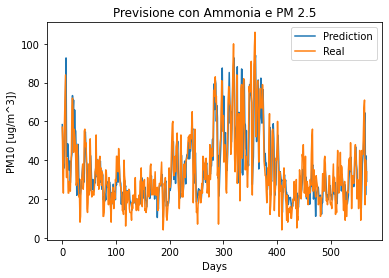

In [16]:
pyplot.plot(inv_yhat, label = 'Prediction')
pyplot.plot(inv_y, label = 'Real')
pyplot.title("Previsione con Ammonia e PM 2.5")
pyplot.xlabel('Days') 
pyplot.ylabel('PM10 [ug/m^3])') 
pyplot.legend()
pyplot.show()

prediction with 2020

In [17]:
#Moggio = table.loc[table.loc[:,"NameStation"]=="Moggio",:]

Moggio = table.loc[:,["Date","PM10","PM25","Ammonia","Wind_speed","Quadrante","Temperature","Rainfall"]]
Moggio = Moggio.dropna(how="any")
Moggio = Moggio.reset_index()
Moggio = Moggio.iloc[:,:] # this is the differrence!!!!
Moggio.head()
values = Moggio.iloc[:,2:].values
# ensure all data is float
values = values.astype('float32') #cast in float 32 bit per evitare problemi
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
n_days = 5 #Memoria della NN
reframed = series_to_supervised(scaled, n_days, 1) # info of the past 5 days to determine next (1) day
# drop columns we don't want to predict (we therefore keep Ammonia)
reframed.drop(reframed.columns[[36, 37,38,39,40,41]], axis=1, inplace=True)


# split into train and test sets
values = reframed.values
n_features = 7 # number of variables, including the one to be predicted
n_train_days = 1312 # we train using only the first year
train = values[:n_train_days, :]
test = values[n_train_days:, :] # we test using all successive years 
# split into input and outputs
n_obs = n_days * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
# reshape from 2D to 3D
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))
test_X = test_X.reshape((test_X.shape[0], n_days, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(1312, 35) 1312 (1312,)
(1312, 5, 7) (1312,) (933, 5, 7) (933,)


In [18]:
# make a prediction
yhat = model.predict(test_X)
#Convert from 3D to 2D
test_X = test_X.reshape((test_X.shape[0], n_days*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 11.434


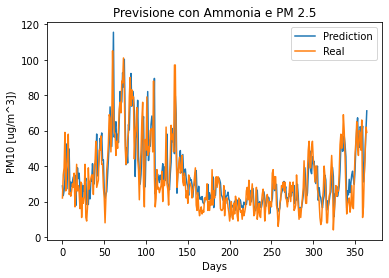

In [19]:
pyplot.plot(inv_yhat[-365:], label = 'Prediction')
pyplot.plot(inv_y[-365:], label = 'Real')
pyplot.title("Previsione con Ammonia e PM 2.5")
pyplot.xlabel('Days') 
pyplot.ylabel('PM10 [ug/m^3])') 
pyplot.legend()
pyplot.show()

# LIME


In [20]:
!pip install lime

     |████████████████████████████████| 275 kB 14.7 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=ef0cc4d6b93396f5c8f16847145ba205127f6c7686add30ea281499f1e240a7c
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [21]:
from lime import lime_tabular

In [22]:
test_X.shape

(933, 35)

In [23]:
train_X = train_X.reshape((train_X.shape[0], n_days, n_features))

In [24]:
explainer = lime_tabular.RecurrentTabularExplainer(train_X, feature_names=["PM10","PM25","Ammonia","Wind_speed","Quadrante","Temperature","Rainfall"], mode='regression')

In [25]:
exp = explainer.explain_instance(train_X[50], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(train_X[49], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [27]:
exp = explainer.explain_instance(train_X[75], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(train_X[345], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(train_X[346], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [30]:
exp = explainer.explain_instance(train_X[347], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [ ]:
exp = explainer.explain_instance(train_X[348], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()

In [32]:
exp = explainer.explain_instance(train_X[349], model.predict, num_features=6,labels=(1,))
exp.show_in_notebook()